Configuration des bras:
Bras 0: Gaussien(0, 1) - moyenne = 0
Bras 1: Bernoulli(0.2) - moyenne = 0.2
Bras 2: Bernoulli(0.25) - moyenne = 0.25
Bras optimal: 2 avec moyenne 0.25
Nombre de simulations: 1000
Horizon temporel: 20000

Début des simulations...
Simulation 100/1000
Simulation 200/1000
Simulation 300/1000
Simulation 400/1000
Simulation 500/1000
Simulation 600/1000
Simulation 700/1000
Simulation 800/1000
Simulation 900/1000
Simulation 1000/1000

=== RÉSULTATS ===
Probabilité moyenne des violations: 0.000061
Probabilité maximale: 0.527000
Regret cumulatif final: 200.56
Probabilité maximale atteinte au temps t=1: 0.527000


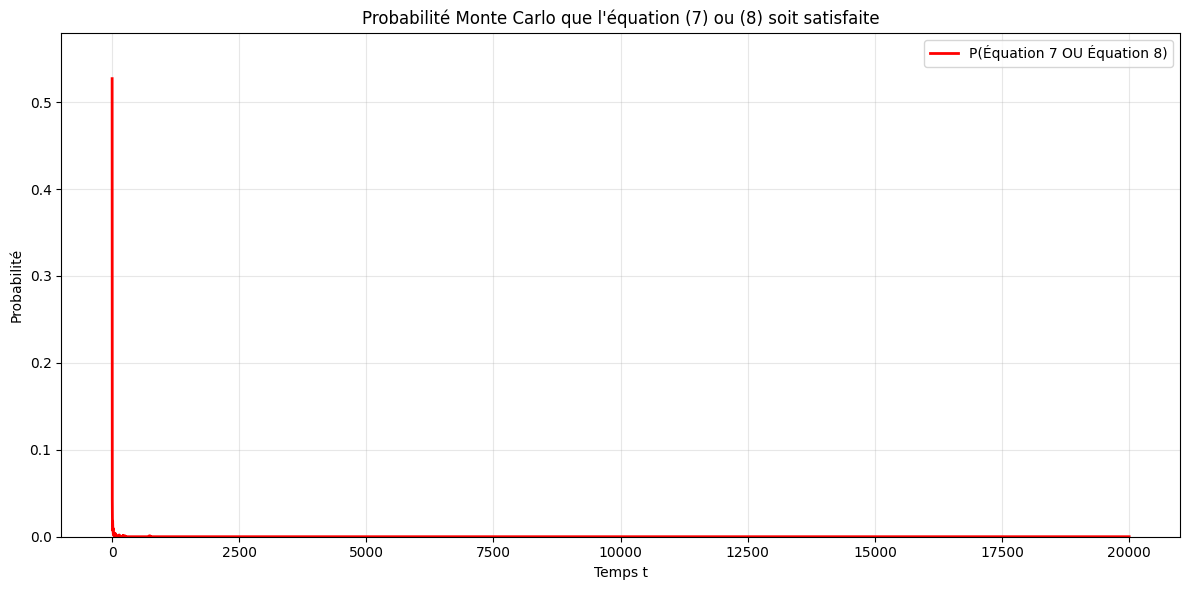

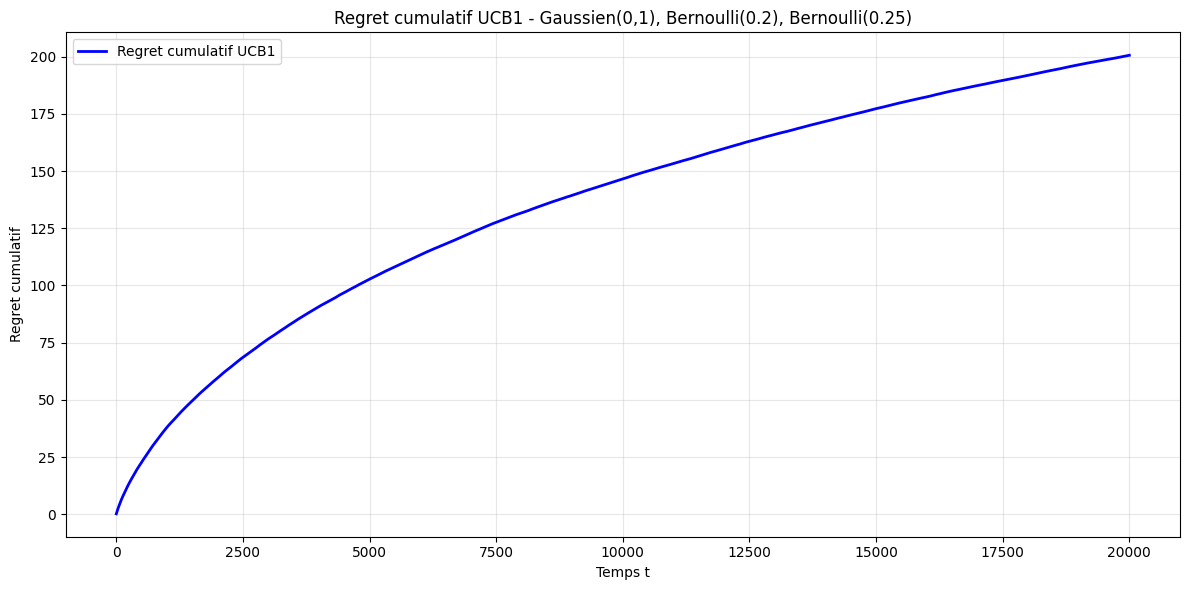


=== ANALYSE DES PREMIERS TOURS ===
Nombre de violations dans les 100 premiers tours: 1.1
Probabilité moyenne sur les 1000 derniers tours: 0.000000

=== TEST DE VALIDATION ===
Violations détectées dans le test de validation: 0/100

Statistiques finales du test:
  Bras 0: empirique = -0.193, vraie = 0.000, tirages = 13
  Bras 1: empirique = 0.200, vraie = 0.200, tirages = 40
  Bras 2: empirique = 0.234, vraie = 0.250, tirages = 47


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Classe pour bras Bernoulli
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def pull(self):
        return np.random.binomial(1, self.p)

# Classe pour bras Gaussien
class GaussianArm:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def pull(self):
        return np.random.normal(self.mean, self.std)

# UCB1 Classique
class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        total_counts = np.sum(self.counts)
        # Phase d'initialisation : jouer chaque bras une fois
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Phase UCB1
        ucb_values = self.values + np.sqrt((2 * np.log(total_counts)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1 / n) * reward

# Paramètres - Configuration identique au code précédent
n_plays = 20000
n_sim = 1000  # Réduit pour des tests plus rapides
print("Configuration des bras:")

# Configuration des bras : Gaussien(0,1), Bernoulli(0.2), Bernoulli(0.25)
arm_configs = [
    ("Gaussien", 0, 1),      # Bras 0: Gaussien standard (mean=0, std=1)
    ("Bernoulli", 0.2, None), # Bras 1: Bernoulli(0.2)
    ("Bernoulli", 0.25, None) # Bras 2: Bernoulli(0.25)
]

# Vraies moyennes des bras
true_means = [0, 0.2, 0.25]
optimal_arm = np.argmax(true_means)  # Bras 2 (Bernoulli 0.25)
mu_max = max(true_means)

print(f"Bras 0: Gaussien(0, 1) - moyenne = {true_means[0]}")
print(f"Bras 1: Bernoulli(0.2) - moyenne = {true_means[1]}")
print(f"Bras 2: Bernoulli(0.25) - moyenne = {true_means[2]}")
print(f"Bras optimal: {optimal_arm} avec moyenne {mu_max}")
print(f"Nombre de simulations: {n_sim}")
print(f"Horizon temporel: {n_plays}")

# Initialisation des bras
def create_arms():
    return [
        GaussianArm(0, 1),      # Bras 0: Gaussien(0,1)
        BernoulliArm(0.2),      # Bras 1: Bernoulli(0.2)
        BernoulliArm(0.25)      # Bras 2: Bernoulli(0.25)
    ]

error_matrix = []
regret_matrix = []

# Simulation principale
print("\nDébut des simulations...")
for sim in range(n_sim):
    if (sim + 1) % 100 == 0:
        print(f"Simulation {sim + 1}/{n_sim}")
    
    # Initialiser l'agent et les bras
    agent = UCB1(n_arms=3)
    arms = create_arms()
    
    # Historique des récompenses pour chaque bras
    rewards = [[] for _ in range(3)]
    errors = []
    cumulative_regret = 0
    regrets = []
    
    for t in range(1, n_plays + 1):
        # Sélectionner un bras
        arm = agent.select_arm()
        
        # Tirer le bras sélectionné et obtenir la récompense
        reward = arms[arm].pull()
        
        # Mettre à jour l'agent
        agent.update(arm, reward)
        rewards[arm].append(reward)
        
        # Calculer le regret instantané
        instantaneous_regret = mu_max - true_means[arm]
        cumulative_regret += instantaneous_regret
        regrets.append(cumulative_regret)
        
        # Calculer les moyennes empiriques et bornes de confiance
        emp_means = [np.mean(r) if len(r) > 0 else 0 for r in rewards]
        s = [len(r) for r in rewards]  # Nombre de tirages par bras
        c_t = [np.sqrt(2 * np.log(t) / si) if si > 0 else np.inf for si in s]
        
        # Détection des erreurs (équations 7 et 8)
        err = 0
        
        # Équation 7: Le bras optimal (bras 2) est sous-estimé
        if s[optimal_arm] > 0 and emp_means[optimal_arm] <= true_means[optimal_arm] - c_t[optimal_arm]:
            err = 1
        
        # Équation 8: Un bras sous-optimal est sur-estimé
        for i in range(3):
            if i != optimal_arm and s[i] > 0:
                if emp_means[i] >= true_means[i] + c_t[i]:
                    err = 1
                    break
        
        errors.append(err)
    
    error_matrix.append(errors)
    regret_matrix.append(regrets)

# Calcul des moyennes Monte Carlo
proba_errors = np.mean(error_matrix, axis=0)
mean_regret = np.mean(regret_matrix, axis=0)

# Statistiques
print(f"\n=== RÉSULTATS ===")
print(f"Probabilité moyenne des violations: {np.mean(proba_errors):.6f}")
print(f"Probabilité maximale: {np.max(proba_errors):.6f}")
print(f"Regret cumulatif final: {mean_regret[-1]:.2f}")

# Moments où la probabilité est maximale
if np.max(proba_errors) > 0:
    max_prob_time = np.argmax(proba_errors) + 1
    print(f"Probabilité maximale atteinte au temps t={max_prob_time}: {np.max(proba_errors):.6f}")

# Affichage des graphiques séparés
# Graphique 1: Probabilité des équations 7 ou 8
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(proba_errors) + 1), proba_errors, color='red', linewidth=2, 
         label="P(Équation 7 OU Équation 8)")
plt.xlabel("Temps t")
plt.ylabel("Probabilité")
plt.title("Probabilité Monte Carlo que l'équation (7) ou (8) soit satisfaite")
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0, max(0.1, np.max(proba_errors) * 1.1))
plt.tight_layout()
plt.show()

# Graphique 2: Regret cumulatif
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(mean_regret) + 1), mean_regret, color='blue', linewidth=2, 
         label="Regret cumulatif UCB1")
plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Regret cumulatif UCB1 - Gaussien(0,1), Bernoulli(0.2), Bernoulli(0.25)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Analyse détaillée des premiers tours pour debug
print(f"\n=== ANALYSE DES PREMIERS TOURS ===")
early_violations = np.sum([proba_errors[i] for i in range(min(100, len(proba_errors)))])
print(f"Nombre de violations dans les 100 premiers tours: {early_violations:.1f}")

# Analyse de convergence
if len(proba_errors) >= 1000:
    final_1000 = np.mean(proba_errors[-1000:])
    print(f"Probabilité moyenne sur les 1000 derniers tours: {final_1000:.6f}")

# Test de validation rapide
print(f"\n=== TEST DE VALIDATION ===")
test_agent = UCB1(n_arms=3)
test_arms = create_arms()
test_violations = 0
test_rewards = [[] for _ in range(3)]

for t in range(1, 101):  # Test sur 100 tours
    arm = test_agent.select_arm()
    reward = test_arms[arm].pull()
    test_agent.update(arm, reward)
    test_rewards[arm].append(reward)
    
    # Vérifier violation
    emp_means = [np.mean(r) if len(r) > 0 else 0 for r in test_rewards]
    s = [len(r) for r in test_rewards]
    c_t = [np.sqrt(2 * np.log(t) / si) if si > 0 else np.inf for si in s]
    
    # Test équations
    violation = False
    if s[optimal_arm] > 0 and emp_means[optimal_arm] <= true_means[optimal_arm] - c_t[optimal_arm]:
        violation = True
    
    for i in range(3):
        if i != optimal_arm and s[i] > 0:
            if emp_means[i] >= true_means[i] + c_t[i]:
                violation = True
                break
    
    if violation:
        test_violations += 1

print(f"Violations détectées dans le test de validation: {test_violations}/100")

# Affichage des statistiques finales du test
print(f"\nStatistiques finales du test:")
final_emp_means = [np.mean(r) if len(r) > 0 else 0 for r in test_rewards]
final_counts = [len(r) for r in test_rewards]
for i in range(3):
    if final_counts[i] > 0:
        print(f"  Bras {i}: empirique = {final_emp_means[i]:.3f}, vraie = {true_means[i]:.3f}, tirages = {final_counts[i]}")

In [2]:
print(proba_errors[:10])

[0.527 0.116 0.07  0.043 0.038 0.025 0.016 0.012 0.016 0.015]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Classe pour bras Bernoulli
class BernoulliArm:
    def __init__(self, p):
        self.p = p

    def pull(self):
        return np.random.binomial(1, self.p)

# Classe pour bras Markovien avec forte dépendance
class MarkovianArm:
    def __init__(self, epsilon):
        self.epsilon = epsilon
        self.state = np.random.choice([0, 1])  # État initial aléatoire
        self.transitions_count = 0  # Pour analyser la persistance
        self.state_changes = 0      # Compteur des changements d'état
        # Matrice de transition: (1-ε, ε; ε, 1-ε)
        # Avec ε très faible, très forte persistance dans l'état actuel
        
    def pull(self):
        old_state = self.state
        
        # Transition d'état selon la matrice Markovienne
        if self.state == 0:
            # Actuellement en état 0, probabilité epsilon (très faible) de passer à 1
            if np.random.random() < self.epsilon:
                self.state = 1
        else:
            # Actuellement en état 1, probabilité epsilon (très faible) de passer à 0
            if np.random.random() < self.epsilon:
                self.state = 0
        
        # Compteurs pour l'analyse
        self.transitions_count += 1
        if old_state != self.state:
            self.state_changes += 1
        
        return self.state

# UCB1 Classique
class UCB1:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)

    def select_arm(self):
        total_counts = np.sum(self.counts)
        # Phase d'initialisation : jouer chaque bras une fois
        for arm in range(self.n_arms):
            if self.counts[arm] == 0:
                return arm
        
        # Phase UCB1
        ucb_values = self.values + np.sqrt((2 * np.log(total_counts)) / self.counts)
        return np.argmax(ucb_values)

    def update(self, arm, reward):
        self.counts[arm] += 1
        n = self.counts[arm]
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1 / n) * reward

# Paramètres de l'expérience
n_plays = 20000
n_sim = 1000
epsilon_markov = 0.01  # Paramètre du bras Markovien - TRÈS FAIBLE pour forte dépendance
p_bernoulli = 0.4      # Probabilité du bras Bernoulli sous-optimal

print("=== CONFIGURATION DE L'EXPÉRIENCE - FORTE DÉPENDANCE MARKOVIENNE ===")
print(f"Bras 0: Bernoulli({p_bernoulli}) - moyenne = {p_bernoulli}")
print(f"Bras 1: Markovien (ε={epsilon_markov}) - moyenne = 0.5 - TRÈS FORTE DÉPENDANCE")
print(f"Matrice de transition Markovienne: [[{1-epsilon_markov:.3f}, {epsilon_markov:.3f}], [{epsilon_markov:.3f}, {1-epsilon_markov:.3f}]]")
print(f"Probabilité de rester dans le même état: {1-epsilon_markov:.3f} (très élevée)")
print(f"Temps moyen entre transitions: {1/epsilon_markov:.0f} tours")

# Vraies moyennes des bras
true_means = [p_bernoulli, 0.5]  # Bernoulli(0.4) et Markovien(0.5)
optimal_arm = np.argmax(true_means)  # Bras 1 (Markovien)
mu_max = max(true_means)

print(f"Bras optimal: {optimal_arm} (Markovien) avec moyenne {mu_max}")
print(f"Écart optimal: {mu_max - true_means[0]:.1f}")
print(f"Nombre de simulations Monte Carlo: {n_sim}")
print(f"Horizon temporel: {n_plays}")

# Initialisation des bras
def create_arms():
    return [
        BernoulliArm(p_bernoulli),          # Bras 0: Bernoulli sous-optimal
        MarkovianArm(epsilon_markov)        # Bras 1: Markovien optimal
    ]

# Matrices pour stocker les résultats
error_matrix = []
regret_matrix = []
equation7_violations = []  # Bras optimal sous-estimé
equation8_violations = []  # Bras sous-optimal sur-estimé
markov_persistence_stats = []  # Statistiques de persistance Markovienne

print("\n=== DÉBUT DES SIMULATIONS MONTE CARLO ===")

# Simulation principale Monte Carlo
for sim in range(n_sim):
    if (sim + 1) % 100 == 0:
        print(f"Simulation {sim + 1}/{n_sim} terminée")
    
    # Initialiser l'agent et les bras pour cette simulation
    agent = UCB1(n_arms=2)
    arms = create_arms()
    
    # Historique des récompenses pour chaque bras
    rewards = [[] for _ in range(2)]
    errors = []
    eq7_violations = []
    eq8_violations = []
    cumulative_regret = 0
    regrets = []
    
    for t in range(1, n_plays + 1):
        # UCB1 sélectionne un bras
        arm = agent.select_arm()
        
        # Tirer le bras sélectionné et obtenir la récompense
        reward = arms[arm].pull()
        
        # Mettre à jour l'agent UCB1
        agent.update(arm, reward)
        rewards[arm].append(reward)
        
        # Calculer le regret instantané
        instantaneous_regret = mu_max - true_means[arm]
        cumulative_regret += instantaneous_regret
        regrets.append(cumulative_regret)
        
        # Calculer les moyennes empiriques des récompenses UCB1
        emp_means = [np.mean(r) if len(r) > 0 else 0 for r in rewards]
        s = [len(r) for r in rewards]  # Nombre de tirages par bras
        c_t = [np.sqrt(2 * np.log(t) / si) if si > 0 else np.inf for si in s]
        
        # Vérification des équations (7) et (8)
        eq7_violation = 0
        eq8_violation = 0
        
        # Équation 7: Le bras optimal (bras 1 Markovien) est sous-estimé
        if s[optimal_arm] > 0 and emp_means[optimal_arm] <= true_means[optimal_arm] - c_t[optimal_arm]:
            eq7_violation = 1
        
        # Équation 8: Le bras sous-optimal (bras 0 Bernoulli) est sur-estimé
        if s[1-optimal_arm] > 0 and emp_means[1-optimal_arm] >= true_means[1-optimal_arm] + c_t[1-optimal_arm]:
            eq8_violation = 1
        
        # Violation globale (équation 7 OU équation 8)
        global_violation = max(eq7_violation, eq8_violation)
        
        errors.append(global_violation)
        eq7_violations.append(eq7_violation)
        eq8_violations.append(eq8_violation)
    
    error_matrix.append(errors)
    regret_matrix.append(regrets)
    equation7_violations.append(eq7_violations)
    equation8_violations.append(eq8_violations)
    
    # Statistiques de persistance du bras Markovien
    markov_arm = arms[1]
    persistence_rate = 1 - (markov_arm.state_changes / markov_arm.transitions_count) if markov_arm.transitions_count > 0 else 0
    markov_persistence_stats.append({
        'transitions': markov_arm.transitions_count,
        'changes': markov_arm.state_changes,
        'persistence_rate': persistence_rate
    })

# Calcul des probabilités Monte Carlo
proba_errors = np.mean(error_matrix, axis=0)
proba_eq7 = np.mean(equation7_violations, axis=0)
proba_eq8 = np.mean(equation8_violations, axis=0)
mean_regret = np.mean(regret_matrix, axis=0)

# Statistiques détaillées
print(f"\n=== RÉSULTATS DE L'ANALYSE MONTE CARLO - FORTE DÉPENDANCE ===")
print(f"Probabilité moyenne des violations globales: {np.mean(proba_errors):.6f}")
print(f"Probabilité maximale globale: {np.max(proba_errors):.6f}")
print(f"Probabilité moyenne Équation 7 (bras optimal sous-estimé): {np.mean(proba_eq7):.6f}")
print(f"Probabilité moyenne Équation 8 (bras sous-optimal sur-estimé): {np.mean(proba_eq8):.6f}")
print(f"Regret cumulatif final: {mean_regret[-1]:.2f}")

# Analyse de la persistance Markovienne
avg_persistence = np.mean([s['persistence_rate'] for s in markov_persistence_stats])
avg_changes = np.mean([s['changes'] for s in markov_persistence_stats])
print(f"\n=== ANALYSE DE LA DÉPENDANCE MARKOVIENNE ===")
print(f"Taux de persistance moyen: {avg_persistence:.4f} ({avg_persistence*100:.2f}%)")
print(f"Nombre moyen de changements d'état par simulation: {avg_changes:.1f}")
print(f"Temps théorique moyen entre transitions: {1/epsilon_markov:.0f} tours")
print(f"Temps observé moyen entre transitions: {n_plays/avg_changes:.1f} tours")

# Moments critiques
if np.max(proba_errors) > 0:
    max_prob_time = np.argmax(proba_errors) + 1
    print(f"Probabilité maximale atteinte au temps t={max_prob_time}: {np.max(proba_errors):.6f}")

# Analyse des premiers tours
early_violations = np.sum([proba_errors[i] for i in range(min(1000, len(proba_errors)))])
print(f"Violations cumulées dans les 1000 premiers tours: {early_violations:.1f}")

# GRAPHIQUES DÉTAILLÉS
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Graphique 1: Probabilités Monte Carlo des équations séparées
time_steps = range(1, len(proba_errors) + 1)

ax1.plot(time_steps, proba_eq7, color='red', linewidth=2, alpha=0.8, 
         label=f"Équation 7: Bras optimal sous-estimé (moy={np.mean(proba_eq7):.4f})")
ax1.plot(time_steps, proba_eq8, color='blue', linewidth=2, alpha=0.8,
         label=f"Équation 8: Bras sous-optimal sur-estimé (moy={np.mean(proba_eq8):.4f})")
ax1.plot(time_steps, proba_errors, color='purple', linewidth=2.5,
         label=f"Union (Éq7 OU Éq8) (moy={np.mean(proba_errors):.4f})")

ax1.set_xlabel("Temps t", fontsize=12)
ax1.set_ylabel("Probabilité Monte Carlo", fontsize=12)
ax1.set_title("Probabilités de violation des équations (7) et (8)\nUCB1: Bernoulli(0.4) vs Markovien TRÈS DÉPENDANT (ε=0.01)", fontsize=13)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_ylim(0, max(0.05, np.max(proba_errors) * 1.1))

# Graphique 2: Vue détaillée des premiers tours
early_steps = min(2000, len(proba_errors))
ax2.plot(range(1, early_steps + 1), proba_eq7[:early_steps], 'r-', linewidth=2, alpha=0.8, label="Équation 7")
ax2.plot(range(1, early_steps + 1), proba_eq8[:early_steps], 'b-', linewidth=2, alpha=0.8, label="Équation 8")
ax2.plot(range(1, early_steps + 1), proba_errors[:early_steps], 'purple', linewidth=2.5, label="Union")

ax2.set_xlabel("Temps t", fontsize=12)
ax2.set_ylabel("Probabilité Monte Carlo", fontsize=12)
ax2.set_title(f"Détail des {early_steps} premiers tours", fontsize=13)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

# Graphique 3: Regret cumulatif
ax3.plot(time_steps, mean_regret, color='green', linewidth=2.5, 
         label=f"Regret UCB1 (final={mean_regret[-1]:.1f})")
ax3.set_xlabel("Temps t", fontsize=12)
ax3.set_ylabel("Regret cumulatif", fontsize=12)
ax3.set_title("Évolution du regret cumulatif", fontsize=13)
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)

# Graphique 4: Histogramme des probabilités maximales par simulation
max_probs_per_sim = [np.max(error_matrix[i]) for i in range(n_sim)]
ax4.hist(max_probs_per_sim, bins=50, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(np.mean(max_probs_per_sim), color='red', linestyle='--', linewidth=2,
            label=f'Moyenne: {np.mean(max_probs_per_sim):.4f}')
ax4.set_xlabel("Probabilité maximale par simulation", fontsize=12)
ax4.set_ylabel("Fréquence", fontsize=12)
ax4.set_title("Distribution des probabilités maximales\n(une valeur par simulation)", fontsize=13)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)

plt.tight_layout()
plt.show()

# Analyse comparative finale
print(f"\n=== ANALYSE COMPARATIVE FINALE - FORTE DÉPENDANCE ===")
print(f"Configuration: Bernoulli({p_bernoulli}) vs Markovien TRÈS DÉPENDANT (ε={epsilon_markov})")
print(f"Écart théorique optimal: {mu_max - true_means[0]:.1f}")
print(f"Impact de la forte dépendance sur les violations d'UCB1:")

# Efficacité de détection des violations
total_violations = np.sum(proba_errors)
eq7_contribution = np.sum(proba_eq7) / total_violations * 100 if total_violations > 0 else 0
eq8_contribution = np.sum(proba_eq8) / total_violations * 100 if total_violations > 0 else 0

print(f"  - Contribution Équation 7: {eq7_contribution:.1f}% des violations")
print(f"  - Contribution Équation 8: {eq8_contribution:.1f}% des violations")

# Convergence temporelle avec forte dépendance
if len(proba_errors) >= 5000:
    final_period = np.mean(proba_errors[-5000:])
    print(f"  - Probabilité stabilisée (5000 derniers tours): {final_period:.6f}")
    
# Impact de la forte persistance sur UCB1
print(f"\nEffet de la très forte dépendance Markovienne:")
print(f"  - Le bras Markovien reste dans le même état ~99% du temps")
print(f"  - UCB1 observe des séquences très longues de 0 ou de 1")
print(f"  - Cela peut créer des biais temporaires dans les estimations empiriques")

=== CONFIGURATION DE L'EXPÉRIENCE - FORTE DÉPENDANCE MARKOVIENNE ===
Bras 0: Bernoulli(0.4) - moyenne = 0.4
Bras 1: Markovien (ε=0.01) - moyenne = 0.5 - TRÈS FORTE DÉPENDANCE
Matrice de transition Markovienne: [[0.990, 0.010], [0.010, 0.990]]
Probabilité de rester dans le même état: 0.990 (très élevée)
Temps moyen entre transitions: 100 tours
Bras optimal: 1 (Markovien) avec moyenne 0.5
Écart optimal: 0.1
Nombre de simulations Monte Carlo: 1000
Horizon temporel: 20000

=== DÉBUT DES SIMULATIONS MONTE CARLO ===
